# Task A

In this task, we had to create a "transform" function which transforms unperformed beats time into a performed version.

In other words, given the `midi_score_annotations.txt` and `NAME_annotations.txt`, we need to create a function that transfers first column of the first file into the first column of the second file.

For the velocity, we use `*.mid` files and extract velocity from events. "Beat velocity" is defined as an average of the velocities of the events close to this beat. Event is close to the beat iff the difference between its onset in score and beat time is smaller than `0.5`. Then we again create a "transform" function.

In [14]:
%load_ext autoreload
%autoreload 2

from src.data import get_dataset_metadata, get_midi_performance_pairs
from src.plots import plot_average_transfer_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df, json_data = get_dataset_metadata("Bach")

In [16]:
df.head(2)

,composer,title,folder,xml_score,midi_score,midi_performance,performance_annotations,midi_score_annotations,maestro_midi_performance,maestro_audio_performance,start,end,audio_performance
0,Bach,Fugue_bwv_846,Bach/Fugue/bwv_846,Bach/Fugue/bwv_846/xml_score.musicxml,Bach/Fugue/bwv_846/midi_score.mid,Bach/Fugue/bwv_846/Shi05M.mid,Bach/Fugue/bwv_846/Shi05M_annotations.txt,Bach/Fugue/bwv_846/midi_score_annotations.txt,{maestro}/2006/MIDI-Unprocessed_19_R1_2006_01-...,{maestro}/2006/MIDI-Unprocessed_19_R1_2006_01-...,144.567708,NaN,Bach/Fugue/bwv_846/Shi05M.wav
1,Bach,Fugue_bwv_848,Bach/Fugue/bwv_848,Bach/Fugue/bwv_848/xml_score.musicxml,Bach/Fugue/bwv_848/midi_score.mid,Bach/Fugue/bwv_848/Denisova06M.mid,Bach/Fugue/bwv_848/Denisova06M_annotations.txt,Bach/Fugue/bwv_848/midi_score_annotations.txt,{maestro}/2008/MIDI-Unprocessed_02_R1_2008_01-...,{maestro}/2008/MIDI-Unprocessed_02_R1_2008_01-...,69.317708,NaN,Bach/Fugue/bwv_848/Denisova06M.wav


In [17]:
# for the first time might take up to 7 min because of velocity
midi_beats_list, velocity_beats_list, performance_beats_list = get_midi_performance_pairs(df, json_data)

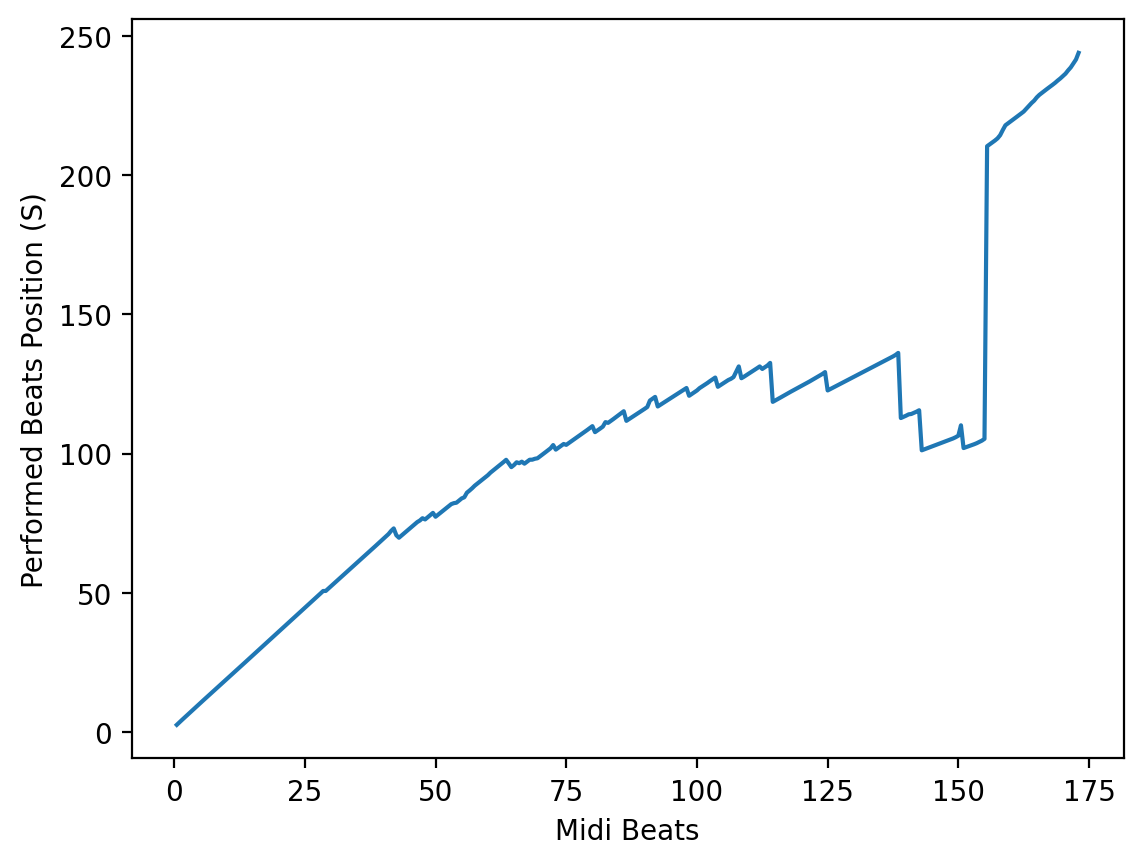

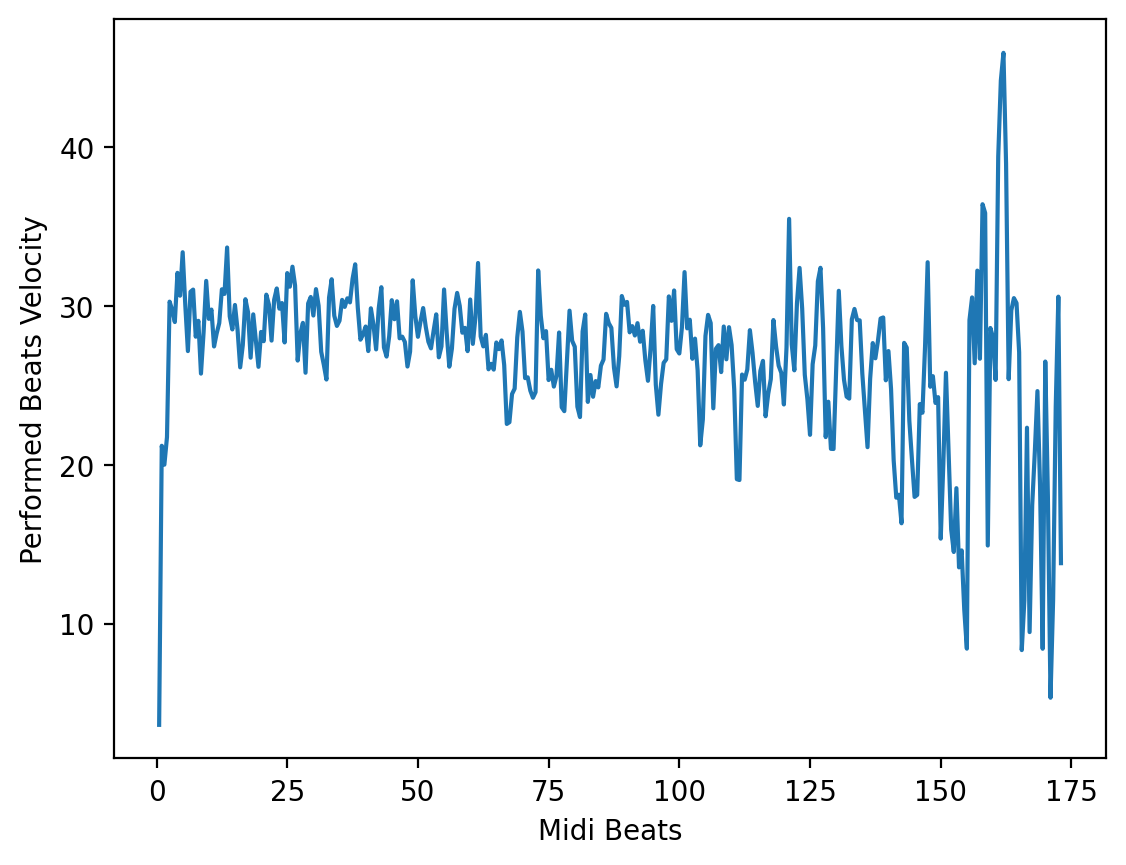

In [18]:
plot_average_transfer_function(midi_beats_list, performance_beats_list, performance_type="time")
plot_average_transfer_function(midi_beats_list, velocity_beats_list, performance_type="velocity")